# **Lab 3: Radial Basis Function (RBF) Networks**
## **Eoin Ocathasaigh - G00417466**

## **Part 1 - Intro to RBF Networks**
An RBF network is a three-layer neural network used for:
- Classification
- Function approximation
- Time series prediction
- System control

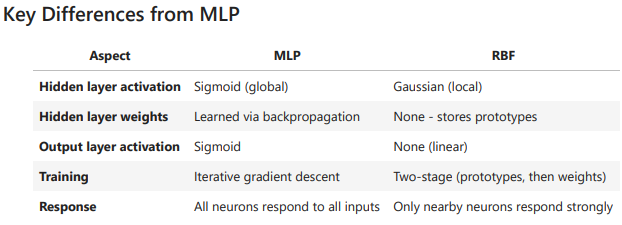

**Key insight:** RBF neurons respond strongly only when the input is close to their prototype. This is fundamentally different from MLP neurons, which respond to weighted sums across the entire input space.

## **Summary**
In this self-study notebook, you'll learn:

1. **RBF Architecture**: Three layers (input → RBF hidden → output) with Gaussian activation
2. **Key Concepts**:
   - **Prototypes**: Training samples stored by RBF neurons
   - **Gaussian activation**: φ(x) = exp(-β||x-p||²)
   - **β parameter**: Controls width of Gaussian response
   - **Local response**: Neurons only activate for nearby inputs
3. **Training Process**:
   - Stage 1: Select prototypes (k-means clustering)
   - Stage 2: Compute β values (from cluster spread)
   - Stage 3: Learn output weights (pseudoinverse)
4. **Comparison with MLP**:
   - RBF uses local Gaussian activation; MLP uses global sigmoid
   - RBF training is faster (no iterative backpropagation)
   - RBF is more interpretable (prototypes are actual data points)
5. **sklearn Alternatives**:
   - SVC with RBF kernel
   - RBFSampler for explicit RBF features

In [2]:
# Import required libraries
# Avoid KMeans memory leak issue on Windows with Intel MKL
import os
os.environ['OMP_NUM_THREADS'] = '1'
import warnings
warnings.filterwarnings('ignore', message='KMeans is known to have a memory leak')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
np.random.seed(42)
print("Libraries loaded successfully!")


Libraries loaded successfully!


## **Exercise 2 - The Gaussian (RBF) Activation Function**
This is the core of the network.

**φ(x) = e^−β⋅||x−p||2**

Where:
- x is the input vector
- p is the prototype (centre) stored by the neuron
- ||x - p|| is the Euclidean distance between input and prototype
- β controls the width of the Gaussian curve

The β Parameter
- Large β → Narrow curve → Neuron responds only to inputs very close to prototype
- Small β → Wide curve → Neuron responds to inputs further from prototype

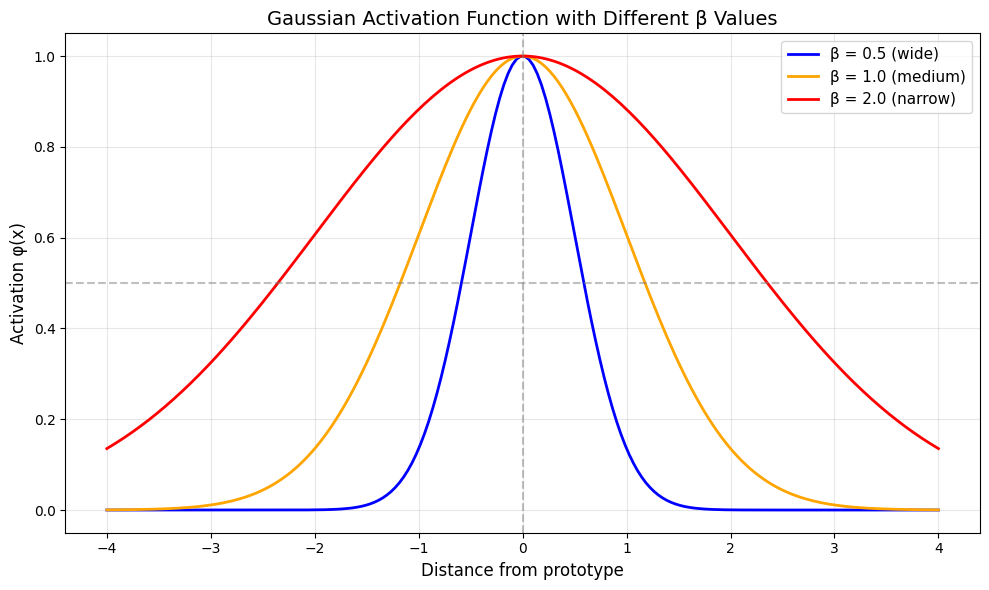


Key observation:
- When input equals prototype (distance = 0), activation = 1.0
- As input moves away from prototype, activation falls towards 0
- β controls how quickly the activation falls off


In [3]:
# Visualise the Gaussian function with different β values
def gaussian(x, centre, beta):
    """
    Compute Gaussian activation.

    Parameters:
        x: Input value(s)
        centre: The prototype/centre of the Gaussian
        beta: Width parameter (larger = narrower curve)
    Returns:
        Activation value(s) in range [0, 1]
    """
    distance_squared = (x - centre) ** 2
    ## TODO: use the numpy's "exp" function to return the gaussian activation
    ## function value (see equation in the markdown cell above)
    return np.exp(-distance_squared / (2 * beta ** 2))

# Create x values
## TODO: use the numpy's "linspace" function to create 200 evenly
## spaced values for x over the interval [-4,4].
x = np.linspace(-4, 4, 200)

centre = 0 # Prototype at origin

# Plot Gaussians with different β values
plt.figure(figsize=(10, 6))
for beta, color, label in [(0.5, 'blue', 'β = 0.5 (wide)'),
                            (1.0, 'orange', 'β = 1.0 (medium)'),
                            (2.0, 'red', 'β = 2.0 (narrow)')]:
    y = gaussian(x, centre, beta)
    plt.plot(x, y, color=color, linewidth=2, label=label)


plt.axhline(y=0.5, color='grey', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='grey', linestyle='--', alpha=0.5)
plt.xlabel('Distance from prototype', fontsize=12)
plt.ylabel('Activation φ(x)', fontsize=12)
plt.title('Gaussian Activation Function with Different β Values', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim(-0.05, 1.05)
plt.tight_layout()
plt.savefig('gaussian_activation.png', dpi=150)
plt.show()

print("\nKey observation:")
print("- When input equals prototype (distance = 0), activation = 1.0")
print("- As input moves away from prototype, activation falls towards 0")
print("- β controls how quickly the activation falls off")

## **Exercise 3 - RBF Network Implementation (From Scratch)**
Now we'll implement a complete RBF network. The training process has two stages:

1. Select prototypes - Choose which training samples (or cluster centres) to use as RBF neuron
centres
2. Learn output weights - Find the weights that map RBF activations to correct outputs

### **Prototype Selection Methods**

From the lecture slides, three options:
1. One RBF neuron for each training sample (expensive)
2. Randomly select k prototypes from the dataset
3. Use k-means clustering and take cluster centroids as prototypes (recommended)

We'll use k-means clustering as it provides well-distributed prototypes.


In [4]:
class RBFNetwork:
    """
    Radial Basis Function Network for classification.

    Architecture:
        - Input layer: passes input directly to hidden layer
        - Hidden layer: RBF neurons, each storing a prototype
        - Output layer: weighted sum (no activation function)

    Training:
        1. Select prototypes using k-means clustering
        2. Compute β from cluster spreads
        3. Learn output weights using pseudoinverse
    """

    def __init__(self, n_prototypes=10):
        """
        Initialise RBF network.

        Parameters:
            n_prototypes: Number of RBF neurons (prototypes) in hidden layer
        """
        self.n_prototypes = n_prototypes
        self.prototypes = None # Will store prototype vectors
        self.betas = None # Will store β for each prototype
        self.weights = None # Will store output layer weights

    def _euclidean_distance(self, x, prototype):
        """
        Compute Euclidean distance between input and prototype.

        ||x - p|| = sqrt(Σ(xᵢ - pᵢ)²)
        """
        ## TODO: use numpy's "sqrt" and "sum" (making axis=-1) functions
        ## to compute and return the Euclidean distance
        return np.sqrt(np.sum((x - prototype) ** 2, axis=-1))

    def _gaussian_activation(self, distance, beta):
        """
        Compute Gaussian activation: φ = exp(-β * d²)

        Parameters:
            distance: Euclidean distance from prototype
            beta: Width parameter

        Returns:
            Activation value in [0, 1]
        """
        return np.exp(-beta * distance ** 2)

    def _compute_hidden_activations(self, X):
        """
        Compute activations of all RBF neurons for all inputs.

        Parameters:
            X: Input data, shape (n_samples, n_features)

        Returns:
            Activation matrix, shape (n_samples, n_prototypes)
        """
        ## TODO: given that 'X' is a 2D NumPy array, read its number of
        ## rows (i.e. samples) into a new variable named "n_samples".
        n_samples = X.shape[0]

        activations = np.zeros((n_samples, self.n_prototypes))

        # For each prototype, compute activation for all samples
        for j, (prototype, beta) in enumerate(zip(self.prototypes, self.betas)):
            distances = self._euclidean_distance(X, prototype)
            activations[:, j] = self._gaussian_activation(distances, beta)

        return activations

    def fit(self, X, y):
        """
        Train the RBF network.

        Stage 1: Select prototypes using k-means clustering
        Stage 2: Compute β values from cluster spreads
        Stage 3: Learn output weights using least squares

        Parameters:
        X: Training data, shape (n_samples, n_features)
        y: Target labels (one-hot encoded), shape (n_samples, n_classes)
        """
        print(f"Training RBF Network with {self.n_prototypes} prototypes...")

        # ============================================================
        # STAGE 1: Select prototypes using k-means clustering
        # ============================================================
        # K-means finds cluster centres that represent the data distribution
        # These centres become our RBF neuron prototypes

        kmeans = KMeans(n_clusters=self.n_prototypes, random_state=42, n_init=10)
        kmeans.fit(X)
        self.prototypes = kmeans.cluster_centers_

        print(f" Stage 1: Selected {self.n_prototypes} prototypes via k-means")

        # ============================================================
        # STAGE 2: Compute β for each prototype
        # ============================================================
        # β = 1 / (2σ²) where σ is the spread of the cluster
        # We use the average distance from cluster centre to its members
        self.betas = np.zeros(self.n_prototypes)

        for j in range(self.n_prototypes):
            # Find all points belonging to this cluster
            cluster_points = X[kmeans.labels_ == j]

            if len(cluster_points) > 1:
                # Compute average distance to cluster centre
                distances = self._euclidean_distance(cluster_points, self.prototypes[j])
                ## TODO: use NumPy's "mean" function to calculate "sigma" as the mean
                ## of the Euclidean "distances"
                sigma = np.mean(distances)

                # Avoid division by zero
                if sigma > 0:
                    self.betas[j] = 1 / (2 * sigma ** 2)
                else:
                    self.betas[j] = 1.0 # Default if all points identical
            else:
                self.betas[j] = 1.0 # Default for single-point cluster
        
        print(f" Stage 2: Computed β values (mean={self.betas.mean():.3f})")

        # ============================================================
        # STAGE 3: Learn output weights using least squares
        # ============================================================
        # We need to find weights W such that: H @ W ≈ Y
        # Where H is the hidden layer activation matrix
        # Solution: W = (H^T H)^(-1) H^T Y (pseudoinverse)

        # Compute hidden layer activations for all training samples
        H = self._compute_hidden_activations(X)

        # Add bias column (column of 1s) to handle offset
        H_bias = np.column_stack([H, np.ones(H.shape[0])])

        # Compute weights using pseudoinverse (more stable than direct inverse)
        # W = pinv(H) @ Y
        self.weights = np.linalg.pinv(H_bias) @ y

        print(f" Stage 3: Learned output weights, shape={self.weights.shape}")
        print("Training complete!")

        return self

    def predict_proba(self, X):
        """
        Predict class probabilities for input samples.

        Parameters:
            X: Input data, shape (n_samples, n_features)

        Returns:
            Class scores, shape (n_samples, n_classes)
        """
        # Compute hidden layer activations
        H = self._compute_hidden_activations(X)

        # Add bias column
        H_bias = np.column_stack([H, np.ones(H.shape[0])])

        # Compute output: weighted sum (no activation function)
        output = H_bias @ self.weights

        return output

    def predict(self, X):
        """
        Predict class labels for input samples.

        Parameters:
            X: Input data, shape (n_samples, n_features)

        Returns:
            Predicted class indices, shape (n_samples,)
        """
        scores = self.predict_proba(X)
        ## TODO: use NumPy's "argmax" function to identify and return the
        ## indices of the highest values for each row of "scores".
        return np.argmax(scores, axis=1)

print("RBFNetwork class defined successfully!")
print("\nKey components:")
print(" - _euclidean_distance(): Computes ||x - p||")
print(" - _gaussian_activation(): Computes exp(-β * d²)")
print(" - fit(): Three-stage training (prototypes, betas, weights)")
print(" - predict(): Classification using trained network")


RBFNetwork class defined successfully!

Key components:
 - _euclidean_distance(): Computes ||x - p||
 - _gaussian_activation(): Computes exp(-β * d²)
 - fit(): Three-stage training (prototypes, betas, weights)
 - predict(): Classification using trained network


## **Exercise 4 - Apply to Iris Dataset**

In [5]:
# Load and prepare the Iris dataset

# Load data
iris = load_iris()
X = iris.data
y = iris.target

print("Iris Dataset")
print("=" * 40)
print(f"Features: {iris.feature_names}")
print(f"Classes: {iris.target_names}")
print(f"Samples: {X.shape[0]}, Features: {X.shape[1]}")

# Normalise features to [0, 1] range
scaler = MinMaxScaler()
X_normalised = scaler.fit_transform(X)

# One-hot encode labels
n_classes = len(np.unique(y))
y_onehot = np.zeros((len(y), n_classes))
for i, label in enumerate(y):
    y_onehot[i, label] = 1

print(f"\nNormalised feature range: [{X_normalised.min():.2f}, {X_normalised.max():.2f}]")
print(f"One-hot encoded labels shape: {y_onehot.shape}")

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_normalised, y_onehot, test_size=0.2, random_state=42, stratify=y
)
y_test_labels = np.argmax(y_test, axis=1)

print(f"\nTraining samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

Iris Dataset
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Classes: ['setosa' 'versicolor' 'virginica']
Samples: 150, Features: 4

Normalised feature range: [0.00, 1.00]
One-hot encoded labels shape: (150, 3)

Training samples: 120
Test samples: 30


In [6]:
# Train the RBF network
# For Iris with 3 classes, we'll use 10 prototypes per class = 30 total
# This follows the slide example: "e.g. 10 samples/class → 3 * 10 = 30 RBF neurons"
n_prototypes = 30
rbf = RBFNetwork(n_prototypes=n_prototypes)
rbf.fit(X_train, y_train);

Training RBF Network with 30 prototypes...
 Stage 1: Selected 30 prototypes via k-means
 Stage 2: Computed β values (mean=91.848)
 Stage 3: Learned output weights, shape=(31, 3)
Training complete!


RBF Network Results
Training Accuracy: 97.50%
Test Accuracy: 96.67%

Confusion Matrix:
[[10  0  0]
 [ 0  9  1]
 [ 0  0 10]]


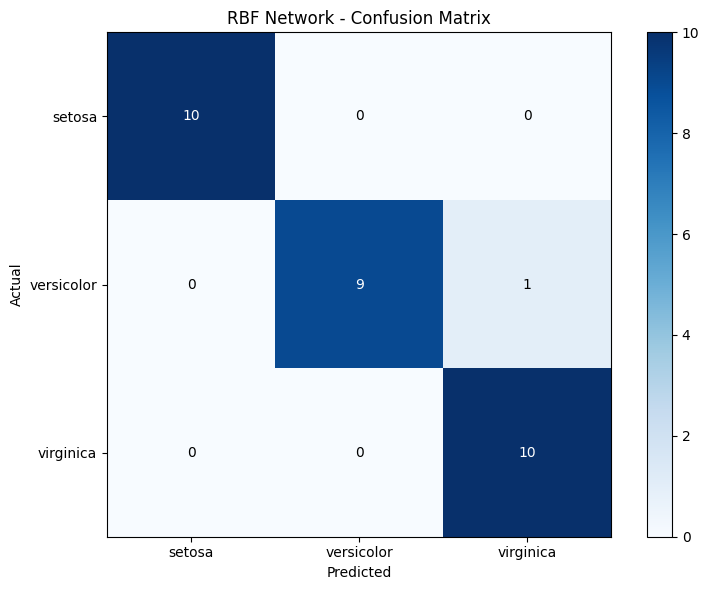

In [7]:
# Evaluate the RBF network

# Predictions
y_train_pred = rbf.predict(X_train)
y_test_pred = rbf.predict(X_test)

# Accuracy
train_accuracy = accuracy_score(np.argmax(y_train, axis=1), y_train_pred)
test_accuracy = accuracy_score(y_test_labels, y_test_pred)

print("RBF Network Results")
print("=" * 40)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Confusion matrix
cm = confusion_matrix(y_test_labels, y_test_pred)
print(f"\nConfusion Matrix:")
print(cm)

# Visualise confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=iris.target_names,
    yticklabels=iris.target_names,
    title='RBF Network - Confusion Matrix',
    ylabel='Actual',
    xlabel='Predicted')

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.savefig('rbf_confusion_matrix.png', dpi=150)
plt.show()

### Visualising the RBF Neuron Activations

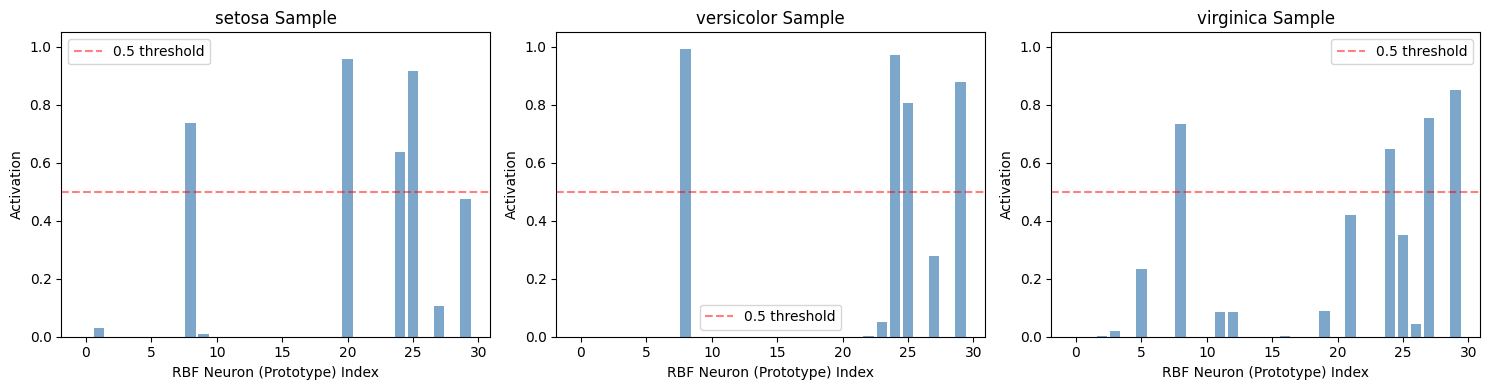


Observation:
Each sample activates only a few RBF neurons strongly (those with similar prototypes).
This is the 'local response' property of RBF networks.


In [8]:

# Visualise RBF activations for sample inputs

# Compute activations for test set
activations = rbf._compute_hidden_activations(X_test)

# Select 3 samples (one from each class)
sample_indices = []
for c in range(3):
    idx = np.where(y_test_labels == c)[0][0]
    sample_indices.append(idx)

# Plot activation patterns
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, (idx, ax) in enumerate(zip(sample_indices, axes)):
    ax.bar(range(rbf.n_prototypes), activations[idx], color='steelblue', alpha=0.7)
    ax.set_xlabel('RBF Neuron (Prototype) Index')
    ax.set_ylabel('Activation')
    ax.set_title(f'{iris.target_names[y_test_labels[idx]]} Sample')
    ax.set_ylim(0, 1.05)
    ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='0.5 threshold')
    ax.legend()

plt.tight_layout()
plt.savefig('rbf_activations.png', dpi=150)
plt.show()

print("\nObservation:")
print("Each sample activates only a few RBF neurons strongly (those with similar prototypes).")
print("This is the 'local response' property of RBF networks.")

## **Exercise 5 - Comparing to MLP**

In [9]:
# Simple MLP implementation (from Lab 2)
class MLP:
    """Multi-Layer Perceptron with one hidden layer."""

    def __init__(self, n_inputs, n_hidden, n_outputs, learning_rate=0.5):
        self.learning_rate = learning_rate

        # Initialise weights randomly in [-0.5, 0.5]
        self.weights_ih = np.random.uniform(-0.5, 0.5, (n_inputs, n_hidden))
        self.bias_h = np.random.uniform(-0.5, 0.5, n_hidden)
        self.weights_ho = np.random.uniform(-0.5, 0.5, (n_hidden, n_outputs))
        self.bias_o = np.random.uniform(-0.5, 0.5, n_outputs)
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

    def forward(self, X):
        self.z_h = np.dot(X, self.weights_ih) + self.bias_h
        self.a_h = self.sigmoid(self.z_h)
        self.z_o = np.dot(self.a_h, self.weights_ho) + self.bias_o
        self.a_o = self.sigmoid(self.z_o)
        return self.a_o

    def backward(self, X, y):
        n_samples = X.shape[0]
        output_error = y - self.a_o
        output_delta = output_error * self.a_o * (1 - self.a_o)
        hidden_error = np.dot(output_delta, self.weights_ho.T)
        hidden_delta = hidden_error * self.a_h * (1 - self.a_h)

        self.weights_ho += self.learning_rate * np.dot(self.a_h.T, output_delta) / n_samples
        self.bias_o += self.learning_rate * np.mean(output_delta, axis=0)
        self.weights_ih += self.learning_rate * np.dot(X.T, hidden_delta) / n_samples
        self.bias_h += self.learning_rate * np.mean(hidden_delta, axis=0)

    def train(self, X, y, epochs, verbose=False):
        losses = []
        for epoch in range(epochs):
            output = self.forward(X)
            loss = np.mean((y - output) ** 2)
            losses.append(loss)
            self.backward(X, y)
            if verbose and epoch % 200 == 0:
                print(f"Epoch {epoch}: MSE = {loss:.6f}")
        return losses

    def predict(self, X):
        output = self.forward(X)
        return np.argmax(output, axis=1)

# Train MLP with same training data
print("Training MLP for comparison...")
print("=" * 40)
np.random.seed(42)
mlp = MLP(n_inputs=4, n_hidden=8, n_outputs=3, learning_rate=0.5)
mlp_losses = mlp.train(X_train, y_train, epochs=1000, verbose=True)

# Evaluate MLP
mlp_train_pred = mlp.predict(X_train)
mlp_test_pred = mlp.predict(X_test)
mlp_train_accuracy = accuracy_score(np.argmax(y_train, axis=1), mlp_train_pred)
mlp_test_accuracy = accuracy_score(y_test_labels, mlp_test_pred)
print(f"\nMLP Training Accuracy: {mlp_train_accuracy * 100:.2f}%")
print(f"MLP Test Accuracy: {mlp_test_accuracy * 100:.2f}%")

Training MLP for comparison...
Epoch 0: MSE = 0.245520
Epoch 200: MSE = 0.192939
Epoch 400: MSE = 0.134717
Epoch 600: MSE = 0.113445
Epoch 800: MSE = 0.104507

MLP Training Accuracy: 90.00%
MLP Test Accuracy: 80.00%



COMPARISON: RBF vs MLP on Iris Dataset

Metric                             RBF          MLP
--------------------------------------------------
Training Accuracy               97.50%       90.00%
Test Accuracy                   96.67%       80.00%
Hidden Neurons                      30            8
Training Method           Pseudoinverse     Backprop
Activation (Hidden)           Gaussian      Sigmoid
Activation (Output)             Linear      Sigmoid


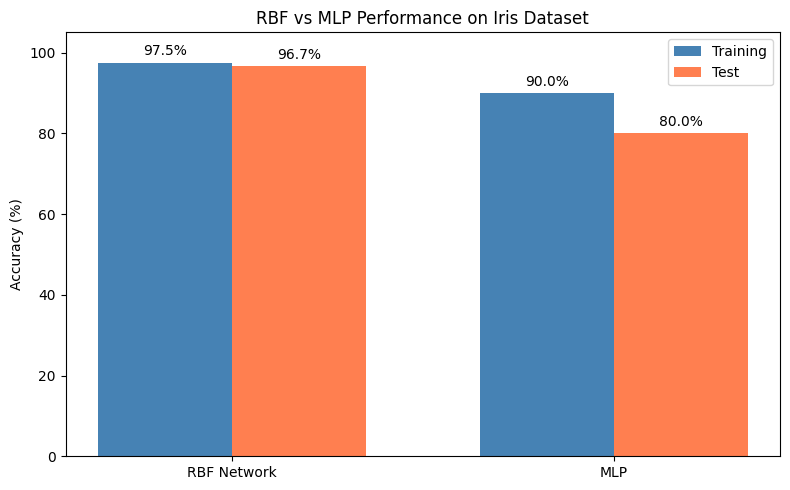

In [10]:
# Compare RBF vs MLP
print("\n" + "=" * 50)
print("COMPARISON: RBF vs MLP on Iris Dataset")
print("=" * 50)
print(f"\n{'Metric':<25} {'RBF':>12} {'MLP':>12}")
print("-" * 50)
print(f"{'Training Accuracy':<25} {train_accuracy*100:>11.2f}% {mlp_train_accuracy*100:>11.2f}%")
print(f"{'Test Accuracy':<25} {test_accuracy*100:>11.2f}% {mlp_test_accuracy*100:>11.2f}%")
print(f"{'Hidden Neurons':<25} {rbf.n_prototypes:>12} {8:>12}")
print(f"{'Training Method':<25} {'Pseudoinverse':>12} {'Backprop':>12}")
print(f"{'Activation (Hidden)':<25} {'Gaussian':>12} {'Sigmoid':>12}")
print(f"{'Activation (Output)':<25} {'Linear':>12} {'Sigmoid':>12}")

# Plot comparison
fig, ax = plt.subplots(figsize=(8, 5))

x_pos = np.arange(2)
width = 0.35

bars1 = ax.bar(x_pos - width/2, [train_accuracy*100, mlp_train_accuracy*100],
    width, label='Training', color='steelblue')
bars2 = ax.bar(x_pos + width/2, [test_accuracy*100, mlp_test_accuracy*100],
    width, label='Test', color='coral')

ax.set_ylabel('Accuracy (%)')
ax.set_title('RBF vs MLP Performance on Iris Dataset')
ax.set_xticks(x_pos)
ax.set_xticklabels(['RBF Network', 'MLP'])
ax.legend()
ax.set_ylim(0, 105)

# Add value labels
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%',
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),
        textcoords="offset points",
        ha='center', va='bottom')

plt.tight_layout()
plt.savefig('rbf_vs_mlp_comparison.png', dpi=150)
plt.show()

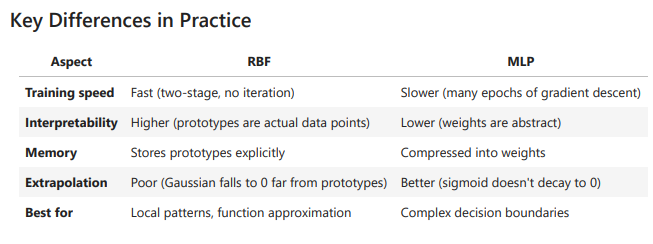

## **Exercise 6 - Using Sklearn (Library Alternative)**

sklearn doesn't have a direct RBF network class, but provides related functionality:

1. **SVC with RBF kernel** - Support Vector Classifier using RBF kernel
2. **RBFSampler** - Approximates RBF kernel features

The SVC with RBF kernel is conceptually similar - it also uses Gaussian functions to measure similarity.

In [11]:
from sklearn.svm import SVC
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline

# Method 1: SVC with RBF kernel
# This uses the RBF (Gaussian) kernel to measure similarity between samples

print("sklearn: SVC with RBF Kernel")
print("=" * 40)
svc_rbf = SVC(kernel='rbf', gamma='scale', random_state=42)
svc_rbf.fit(X_train, np.argmax(y_train, axis=1))

svc_train_accuracy = svc_rbf.score(X_train, np.argmax(y_train, axis=1))
svc_test_accuracy = svc_rbf.score(X_test, y_test_labels)

print(f"Number of RBF kernels: {len(svc_rbf.support_)}")
print(f"Training Accuracy: {svc_train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {svc_test_accuracy * 100:.2f}%")

sklearn: SVC with RBF Kernel
Number of RBF kernels: 38
Training Accuracy: 97.50%
Test Accuracy: 96.67%


In [12]:
# Method 2: RBFSampler + Linear Classifier
# This explicitly creates RBF features, similar to our from-scratch approach

print("\nsklearn: RBFSampler + Linear Classifier")
print("=" * 40)

# Create pipeline: RBF features → Linear classifier
rbf_pipeline = make_pipeline(
 RBFSampler(gamma=1.0, n_components=30, random_state=42), # 30 RBF features
 SGDClassifier(max_iter=1000, random_state=42)
)

rbf_pipeline.fit(X_train, np.argmax(y_train, axis=1))

rbf_pipe_train_accuracy = rbf_pipeline.score(X_train, np.argmax(y_train, axis=1))
rbf_pipe_test_accuracy = rbf_pipeline.score(X_test, y_test_labels)

print(f"Training Accuracy: {rbf_pipe_train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {rbf_pipe_test_accuracy * 100:.2f}%")


sklearn: RBFSampler + Linear Classifier
Training Accuracy: 98.33%
Test Accuracy: 96.67%


In [13]:
# Summary comparison

print("\n" + "=" * 60)
print("SUMMARY: All Methods Compared")
print("=" * 60)

methods = [
 ('Our RBF (from scratch)', test_accuracy),
 ('Our MLP (from scratch)', mlp_test_accuracy),
 ('sklearn SVC + RBF kernel', svc_test_accuracy),
 ('sklearn RBFSampler + SGD', rbf_pipe_test_accuracy),
]

print(f"\n{'Method':<30} {'Test Accuracy':>15}")

print("-" * 45)
for method, acc in methods:
    print(f"{method:<30} {acc*100:>14.2f}%")

print("\nNote: sklearn's SVC with RBF kernel is a powerful classifier that")
print("uses the same Gaussian similarity concept as RBF networks.")


SUMMARY: All Methods Compared

Method                           Test Accuracy
---------------------------------------------
Our RBF (from scratch)                  96.67%
Our MLP (from scratch)                  80.00%
sklearn SVC + RBF kernel                96.67%
sklearn RBFSampler + SGD                96.67%

Note: sklearn's SVC with RBF kernel is a powerful classifier that
uses the same Gaussian similarity concept as RBF networks.


## **Exercise 7 - Experimental Exercises**

Effect of Number of Prototypes
Training RBF Network with 5 prototypes...
 Stage 1: Selected 5 prototypes via k-means
 Stage 2: Computed β values (mean=25.701)
 Stage 3: Learned output weights, shape=(6, 3)
Training complete!
Prototypes:   5 | Train: 90.8% | Test: 86.7%
Training RBF Network with 10 prototypes...
 Stage 1: Selected 10 prototypes via k-means
 Stage 2: Computed β values (mean=38.939)
 Stage 3: Learned output weights, shape=(11, 3)
Training complete!
Prototypes:  10 | Train: 95.0% | Test: 100.0%
Training RBF Network with 15 prototypes...
 Stage 1: Selected 15 prototypes via k-means
 Stage 2: Computed β values (mean=46.592)
 Stage 3: Learned output weights, shape=(16, 3)
Training complete!
Prototypes:  15 | Train: 95.8% | Test: 100.0%
Training RBF Network with 20 prototypes...
 Stage 1: Selected 20 prototypes via k-means
 Stage 2: Computed β values (mean=59.997)
 Stage 3: Learned output weights, shape=(21, 3)
Training complete!
Prototypes:  20 | Train: 96.7% | Test: 96.7%
Tr

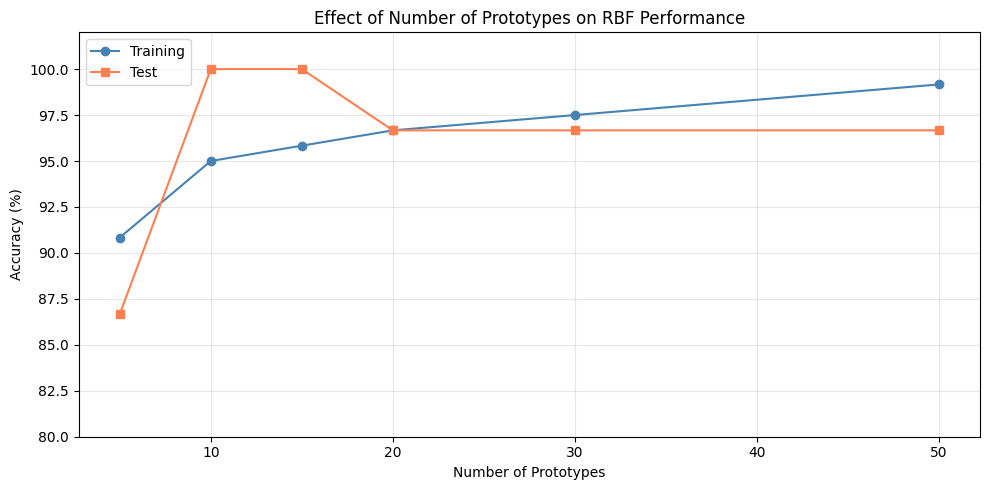


Observations:
- Too few prototypes: underfitting (network can't represent the data)
- Too many prototypes: overfitting risk and slower computation
- Sweet spot depends on dataset complexity


In [14]:
# Experiment: Effect of number of prototypes

prototype_counts = [5, 10, 15, 20, 30, 50]
results = []

print("Effect of Number of Prototypes")
print("=" * 40)

for n_proto in prototype_counts:
    rbf_exp = RBFNetwork(n_prototypes=n_proto)
    rbf_exp.fit(X_train, y_train)

    train_acc = accuracy_score(np.argmax(y_train, axis=1), rbf_exp.predict(X_train))
    test_acc = accuracy_score(y_test_labels, rbf_exp.predict(X_test))

    results.append((n_proto, train_acc, test_acc))
    print(f"Prototypes: {n_proto:3d} | Train: {train_acc*100:.1f}% | Test: {test_acc*100:.1f}%")

# Plot results
fig, ax = plt.subplots(figsize=(10, 5))

proto, train_accs, test_accs = zip(*results)
ax.plot(proto, [a*100 for a in train_accs], 'o-', label='Training', color='steelblue')
ax.plot(proto, [a*100 for a in test_accs], 's-', label='Test', color='coral')

ax.set_xlabel('Number of Prototypes')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Effect of Number of Prototypes on RBF Performance')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(80, 102)

plt.tight_layout()
plt.savefig('rbf_prototype_experiment.png', dpi=150)
plt.show()

print("\nObservations:")
print("- Too few prototypes: underfitting (network can't represent the data)")
print("- Too many prototypes: overfitting risk and slower computation")
print("- Sweet spot depends on dataset complexity")

### Exercise 7.2 - Experiment with β Values

Effect of Fixed β Values
β =   0.1 | Test Accuracy: 100.0%
β =   0.5 | Test Accuracy: 96.7%
β =   1.0 | Test Accuracy: 96.7%
β =   2.0 | Test Accuracy: 96.7%
β =   5.0 | Test Accuracy: 96.7%
β =  10.0 | Test Accuracy: 93.3%


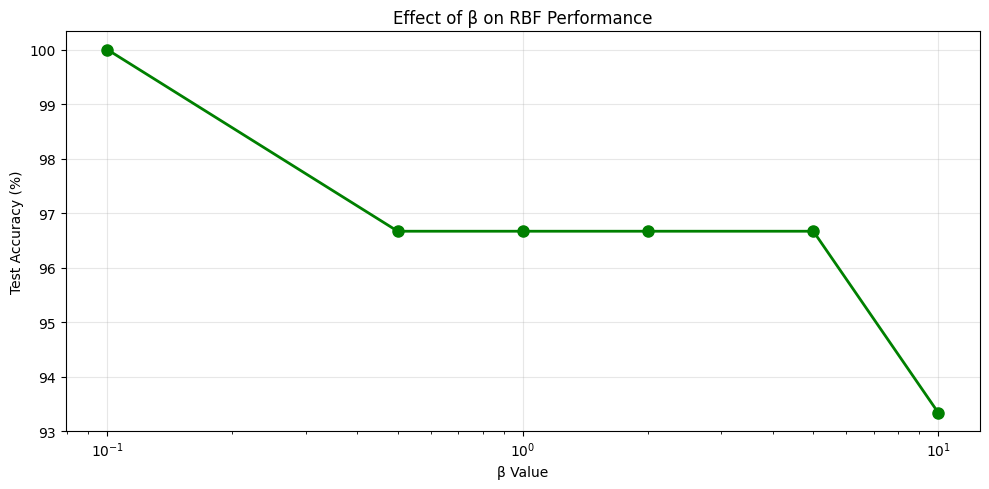


Observations:
- Small β: Wide Gaussians, neurons respond to distant inputs (underfitting)
- Large β: Narrow Gaussians, neurons only respond to very close inputs (overfitting)
- Computing β from data (as we did originally) usually gives good results


In [15]:
# Experiment: Effect of fixed β values
class RBFNetworkFixedBeta(RBFNetwork):
    """RBF Network with fixed (not computed) beta value."""

    def __init__(self, n_prototypes=10, fixed_beta=1.0):
        super().__init__(n_prototypes)
        self.fixed_beta = fixed_beta

    def fit(self, X, y):
        # Stage 1: Select prototypes (same as before)
        kmeans = KMeans(n_clusters=self.n_prototypes, random_state=42, n_init=10)
        kmeans.fit(X)
        self.prototypes = kmeans.cluster_centers_

        # Stage 2: Use fixed beta instead of computing from data
        self.betas = np.full(self.n_prototypes, self.fixed_beta)

        # Stage 3: Learn weights (same as before)
        H = self._compute_hidden_activations(X)
        H_bias = np.column_stack([H, np.ones(H.shape[0])])
        self.weights = np.linalg.pinv(H_bias) @ y

        return self

beta_values = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
beta_results = []

print("Effect of Fixed β Values")
print("=" * 40)
for beta in beta_values:
    rbf_beta = RBFNetworkFixedBeta(n_prototypes=30, fixed_beta=beta)
    rbf_beta.fit(X_train, y_train)

    test_acc = accuracy_score(y_test_labels, rbf_beta.predict(X_test))
    beta_results.append((beta, test_acc))
    print(f"β = {beta:5.1f} | Test Accuracy: {test_acc*100:.1f}%")

# Plot
fig, ax = plt.subplots(figsize=(10, 5))

betas, accs = zip(*beta_results)
ax.plot(betas, [a*100 for a in accs], 'o-', color='green', linewidth=2, markersize=8)

ax.set_xlabel('β Value')
ax.set_ylabel('Test Accuracy (%)')
ax.set_title('Effect of β on RBF Performance')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('rbf_beta_experiment.png', dpi=150)
plt.show()

print("\nObservations:")
print("- Small β: Wide Gaussians, neurons respond to distant inputs (underfitting)")
print("- Large β: Narrow Gaussians, neurons only respond to very close inputs (overfitting)")
print("- Computing β from data (as we did originally) usually gives good results")